In [1]:
pip install allensdk

In [55]:
from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache(manifest_file = 'cell_types/manifest.json')

cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

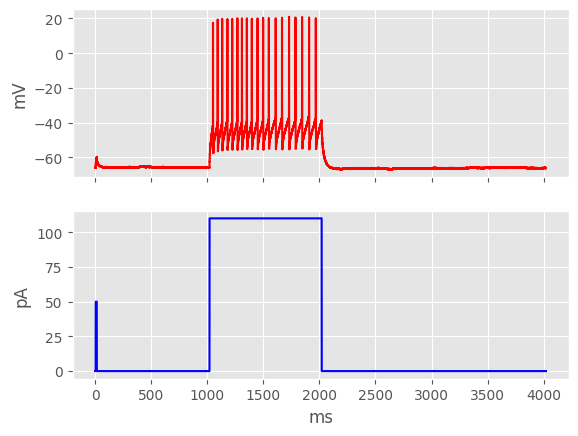

In [56]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1] + 1] # in A
v = sweep_data["response"][0:index_range[1] + 1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)
t *= 1000 # to ms

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex = True)
axes[0].plot(t, v, color = 'red')
axes[1].plot(t, i, color = 'blue')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("ms")
plt.show()

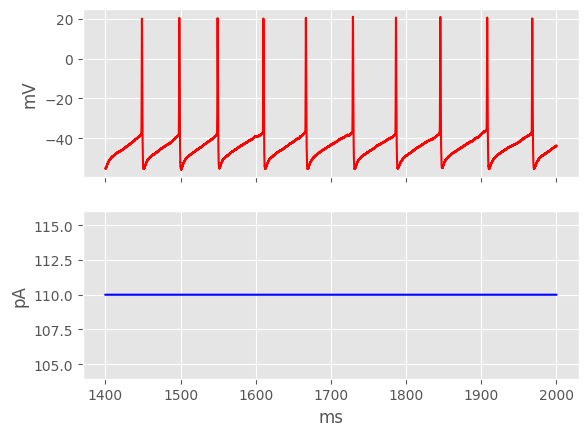

In [57]:
mask = (t>= 1400) & (t <= 2000)
t = t[mask]
v = v[mask]
i = i[mask]

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex = True)
axes[0].plot(t, v, color = 'red')
axes[1].plot(t, i, color = 'blue')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("ms")
plt.show()

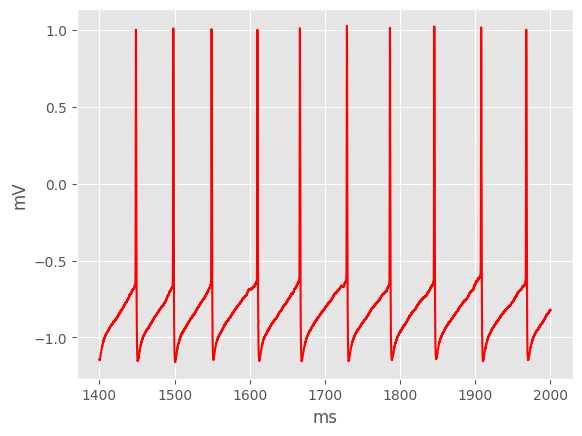

In [58]:
downsample_indices = np.arange(0, len(v), 6)

v_d = v[downsample_indices]
t_d = t[downsample_indices]

v_min = -50
v_max = 20

v_d = 2 * (v_d - v_min) / (v_max - v_min) - 1

plt.style.use('ggplot')
plt.plot(t_d, v_d, color = 'red')
plt.ylabel("mV")
plt.xlabel("ms")
plt.show()

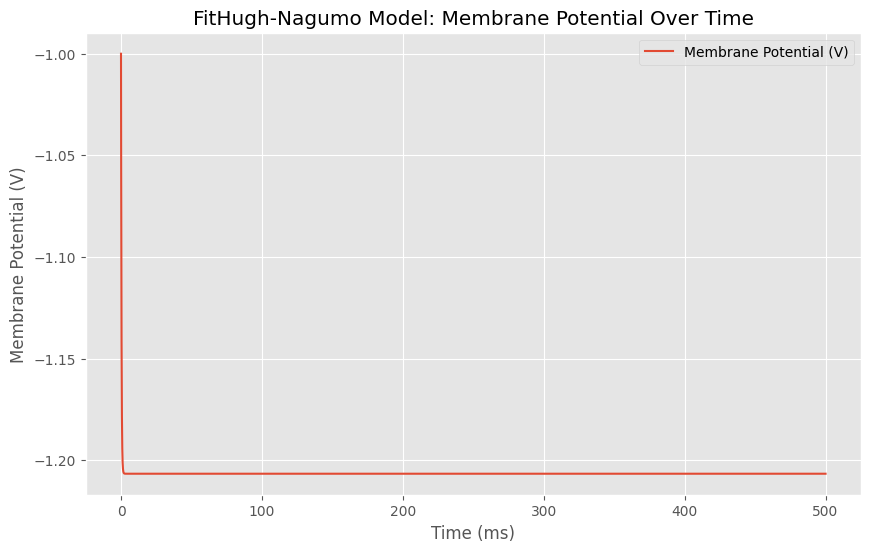

In [36]:
a = 0.3
b = 0.9
epsilon = 0.07
I = -0.55
t_max = 500
dt = 0.0001
time = np.arange(0, t_max, dt)

V = np.zeros(len(time))
W = np.zeros(len(time))

V[0] = -1.0
W[0] = 1.0

for i in range(1, len(time)):

  dV = (dt * (V[ i -1] - (V[i - 1]**3) - W[i - 1] + I)) # dV/dt
  V[i] = V[i - 1] + dV

plt.figure(figsize = (10, 6))
plt.plot(time, V, label = 'Membrane Potential (V)')
plt.title('FitHugh-Nagumo Model: Membrane Potential Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (V)')
plt.legend()
plt.show()

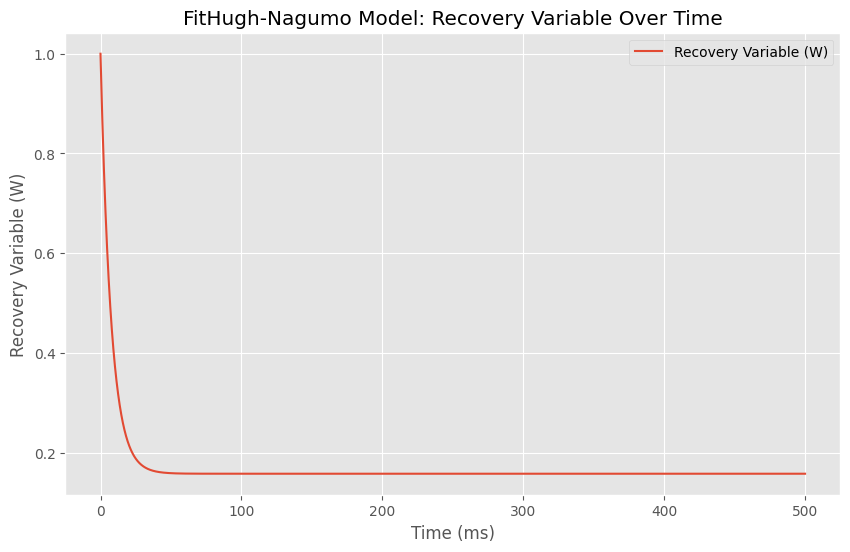

In [37]:
a = 0.3
b = 1.9
epsilon = 0.07
I = 0.11
t_max = 500
dt = 0.0001
time = np.arange(0, t_max, dt)

V = np.zeros(len(time))
W = np.zeros(len(time))

V[0] = -1.0
W[0] = 1.0

for i in range(1, len(time)):

  dW = dt * (epsilon * ((V[i - 1]) + a - b * W[i - 1])) # dW/dt
  W[i] = W[i - 1] + dW

plt.figure(figsize = (10, 6))
plt.plot(time, W, label = 'Recovery Variable (W)')
plt.title('FitHugh-Nagumo Model: Recovery Variable Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Recovery Variable (W)')
plt.legend()
plt.show()

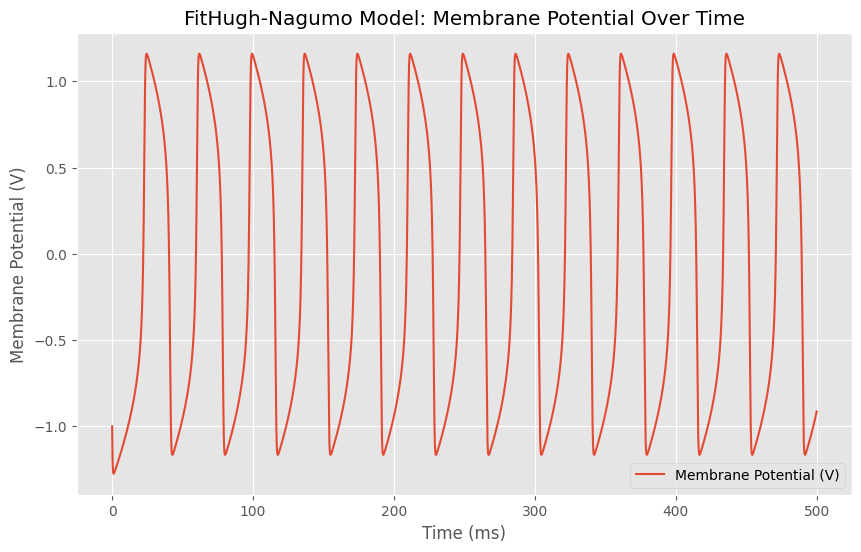

In [38]:
a = 0.03
b = 0.09
epsilon = 0.07
I = 0.11
t_max = 500
dt = 0.0001
time = np.arange(0, t_max, dt)

V = np.zeros(len(time))
W = np.zeros(len(time))

V[0] = -1.0
W[0] = 1.0

for i in range(1, len(time)):

  dV = (dt * (V[ i -1] - (V[i - 1]**3) - W[i - 1] + I)) # dV/dt
  dW = dt * (epsilon * ((V[i - 1]) + a - b * W[i - 1])) # dW/dt

  V[i] = V[i - 1] + dV
  W[i] = W[i - 1] + dW

plt.figure(figsize = (10, 6))
plt.plot(time, V, label = 'Membrane Potential (V)')
plt.title('FitHugh-Nagumo Model: Membrane Potential Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (V)')
plt.legend()
plt.show()

Best Parameters: (0.7954769576009131, 0.21587220783234157, 0.05636928370541837)
Best Cost: 1093.984358530162


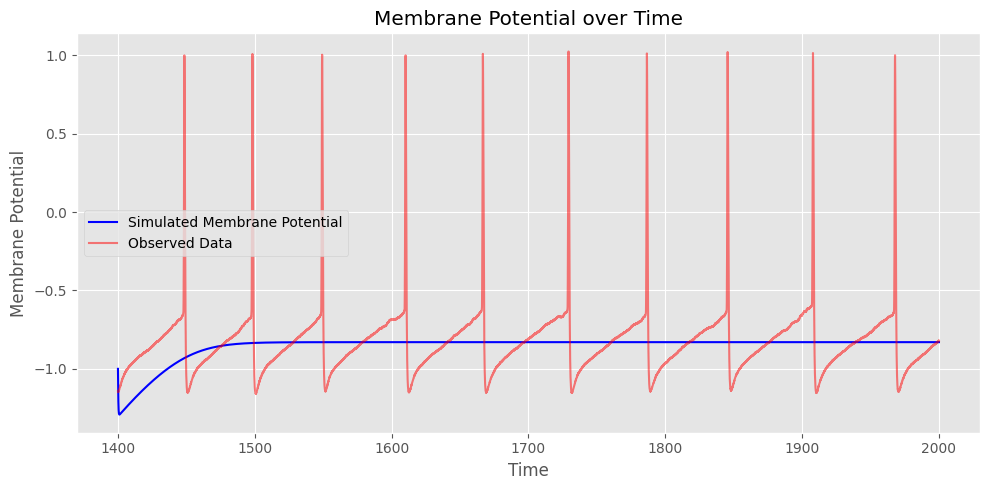

In [48]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class FitzHughNagumoModel:
  def __init__(self, a, b, epsilon, V0, W0):
    self.a = a
    self.b = b
    self.epsilon = epsilon
    self.I = 0.1
    self.V = V0
    self.W = W0
    self.history = {'V' : [V0], 'W' : [W0]}

  def simulate(self, num_steps, dt):
    for t in range(num_steps):
      dVdt = self.V - (self.V**3) - self.W + self.I
      dWdt = self.epsilon * (self.V + self.a - self.b * self.W)
      self.V += dVdt * dt
      self.W += dWdt * dt

      self.history['V'].append(self.V)
      self.history['W'].append(self.W)


def cost_function(a, b, epsilon, dt, observed_v, observed_t):
  V0 = observed_v[0]
  W0 = 1
  model = FitzHughNagumoModel(a, b, epsilon, V0, W0)

  total_time = observed_t[-1] - observed_t[0]
  num_steps = int(total_time / dt)

  model.simulate(num_steps, dt)

  time_points = np.linspace(observed_t[0], observed_t[-1], num_steps + 1)

  sim_interp = interp1d(time_points, model.history['V'], kind = 'linear',
                        fill_value = 'extrapolate')

  simulated_at_observed = sim_interp(observed_t)

  return np.sum((observed_v - simulated_at_observed) ** 2)

def simulated_anneling_fitzhugh(observed_v, observed_t, dt):
  best_params = (0.8, 0.2, 0.07)
  best_cost = np.inf
  temp = 200
  temp_min = 0.300
  alpha = 0.400
  perturb_scale = 0.01

  while temp > temp_min:
    a_try = best_params[0] + np.random.uniform(-perturb_scale, perturb_scale)
    b_try = best_params[1] + np.random.uniform(-perturb_scale, perturb_scale)
    epsilon_try = best_params[2] + np.random.uniform(-perturb_scale, perturb_scale / 10)

    cost_current = cost_function(best_params[0], best_params[1], best_params[2],
                                 dt, observed_v, observed_t)

    cost_try = cost_function(a_try, b_try, epsilon_try, dt, observed_v,
                             observed_t)

    if cost_try < best_cost or np.random.rand() < np.exp((cost_current - cost_try) / temp):
      best_params = (a_try, b_try, epsilon_try)
      best_cost = cost_try

    temp *= alpha

  return best_params, best_cost

dt = 0.1

best_params, best_cost = simulated_anneling_fitzhugh(v_d, t_d, dt)

print("Best Parameters:", best_params)
print("Best Cost:", best_cost)

a_opt, b_opt, epsilon_opt = best_params

model = FitzHughNagumoModel(a_opt, b_opt, epsilon_opt, -1, 1)

num_steps = int((t_d[-1] - t_d[0]) / dt)

model. simulate(num_steps, dt)

time_points = np.linspace(t_d[0], t_d[-1], num_steps + 1)

plt.figure(figsize = (10, 5))
plt.plot(time_points, model.history['V'], color = 'blue', label = 'Simulated Membrane Potential')
plt.plot(t_d, v_d, color = 'red', label = 'Observed Data', alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential over Time")
plt.legend()

plt.tight_layout()
plt.show()

Iteration 0: Cost = 1401.0442237080103
Iteration 100: Cost = 1400.9900482338135
Iteration 200: Cost = 1400.9358785643328
Iteration 300: Cost = 1400.8817146991482
Iteration 400: Cost = 1400.8275566381808
Iteration 500: Cost = 1400.7734043810635
Iteration 600: Cost = 1400.7192579271775
Iteration 700: Cost = 1400.6651172764189
Iteration 800: Cost = 1400.610982428053
Iteration 900: Cost = 1400.5568533821124


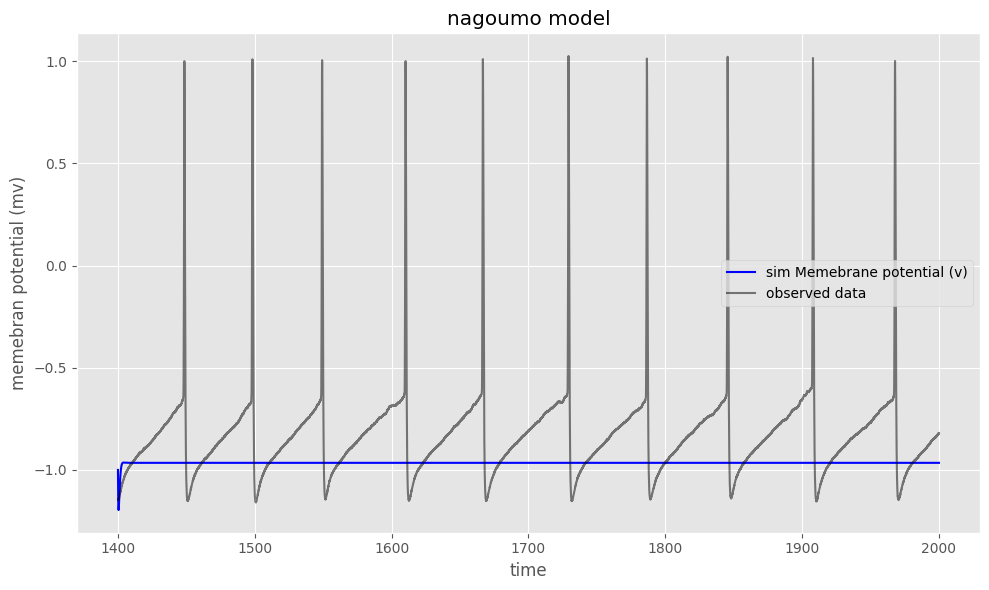

In [49]:
from scipy.interpolate import interp1d

def numerical_gradient(params, k, dt, v, t):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_forward = np.array(params)
        params_forward[i] += k  # Increment the i-th parameter by epsilon to get 'b'
        # Compute the forward difference approximation of the derivative
        grad[i] = (cost_function(params_forward[0], params_forward[1], params_forward[2], dt, v, t) -
                   cost_function(params[0], params[1], params[2], dt, v, t )) / epsilon
    return grad


def gradient_descent(v, t, dt, learning_rate=0.001, k=1e-8, max_iterations=1000):
    params = np.array([1.0,1.0,1.0], dtype=np.float64)
    cost_history = []

    for iteration in range(max_iterations):
        grad = numerical_gradient(params, k, dt, v, t)
        params -= learning_rate * grad
        cost = cost_function(params[0], params[1], params[2], dt, v, t)
        cost_history.append(cost)


        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Cost = {cost}")

    return params

dt=0.1

best_prams=gradient_descent(v_d,t_d,dt)

a_best,b_best,epsilon_best=best_prams

model=FitzHughNagumoModel(a_best,b_best,epsilon_best,-1,1)

num_steps=int((t_d[-1]-t_d[0])/dt)

model.simulate(num_steps,dt)

time_points=np.linspace(t_d[0],t_d[-1],num_steps+1)


plt.figure(figsize=(10,6))
plt.plot(time_points,model.history['V'],color='blue',label="sim Memebrane potential (v)")
plt.plot(t_d,v_d,label="observed data",color="black",alpha=0.5)
plt.title('nagoumo model')
plt.xlabel('time')
plt.ylabel("memebran potential (mv)")
plt.legend()
plt.tight_layout()
plt.show()

Generation 0: Best Cost = 1028.0089197452407


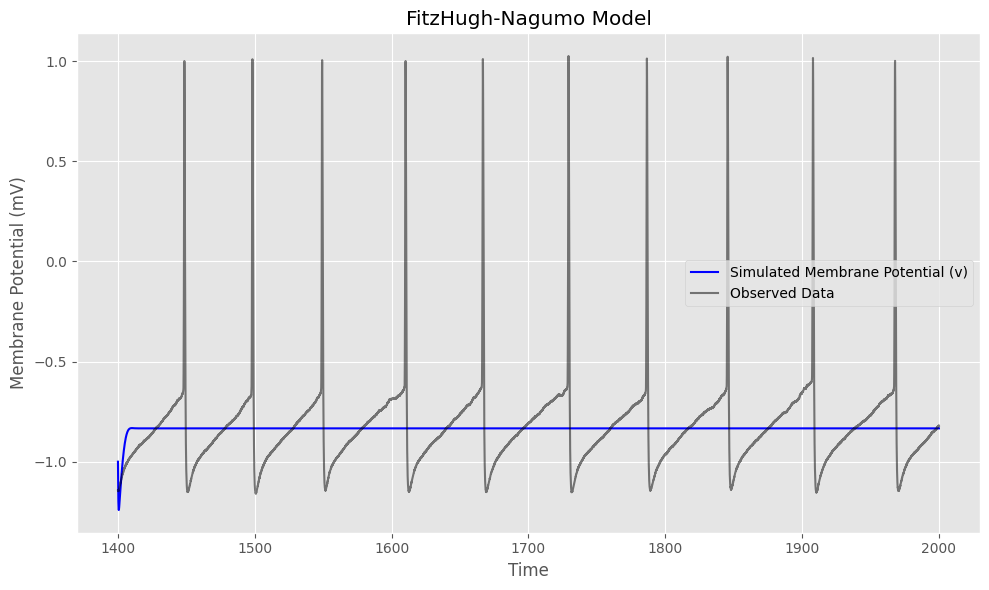

In [50]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def genetic_algorithm(v, t, dt, population_size=10, generations=100, mutation_rate=0.01, elitism_rate=0.1):
    def initialize_population():
        return np.random.rand(population_size, 3)

    def select_parents(population, fitness):
        fitness_prob = fitness / np.sum(fitness)
        return population[np.random.choice(np.arange(population_size), size=population_size, p=fitness_prob)]

    def crossover(parents):
        offsprings = []
        for i in range(0, population_size, 2):
            parent1 = parents[i]
            parent2 = parents[(i+1) % population_size]
            cross_point = np.random.randint(1, 3)
            offspring1 = np.concatenate((parent1[:cross_point], parent2[cross_point:]))
            offspring2 = np.concatenate((parent2[:cross_point], parent1[cross_point:]))
            offsprings.append(offspring1)
            offsprings.append(offspring2)
        return np.array(offsprings)

    def mutate(offsprings):
        for offspring in offsprings:
            if np.random.rand() < mutation_rate:
                mutate_idx = np.random.randint(0, 3)
                offspring[mutate_idx] = np.random.rand()
        return offsprings

    population = initialize_population()
    best_params = None
    best_cost = float('inf')

    for generation in range(generations):
        fitness = np.array([1 / (cost_function(ind[0], ind[1], ind[2], dt, v, t) + 1e-8) for ind in population])
        best_idx = np.argmax(fitness)
        if 1 / fitness[best_idx] < best_cost:
            best_cost = 1 / fitness[best_idx]
            best_params = population[best_idx]

        parents = select_parents(population, fitness)
        offsprings = crossover(parents)
        population = mutate(offsprings)

        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cost = {best_cost}")

    return best_params

dt = 0.1

best_params = genetic_algorithm(v_d, t_d, dt)
a_best, b_best, epsilon_best = best_params

model = FitzHughNagumoModel(a_best, b_best, epsilon_best, -1, 1)
num_steps = int((t_d[-1] - t_d[0]) / dt)
model.simulate(num_steps, dt)

time_points = np.linspace(t_d[0], t_d[-1], num_steps + 1)

plt.figure(figsize=(10, 6))
plt.plot(time_points, model.history['V'], color='blue', label="Simulated Membrane Potential (v)")
plt.plot(t_d, v_d, label="Observed Data", color="black", alpha=0.5)
plt.title('FitzHugh-Nagumo Model')
plt.xlabel('Time')
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
dt = 0.1
best_params_gd = gradient_descent(v_d, t_d, dt)
a_gd, b_gd, epsilon_gd = best_params_gd

Iteration 0: Cost = 1401.0442237080103
Iteration 100: Cost = 1400.9900482338135
Iteration 200: Cost = 1400.9358785643328
Iteration 300: Cost = 1400.8817146991482
Iteration 400: Cost = 1400.8275566381808
Iteration 500: Cost = 1400.7734043810635
Iteration 600: Cost = 1400.7192579271775
Iteration 700: Cost = 1400.6651172764189
Iteration 800: Cost = 1400.610982428053
Iteration 900: Cost = 1400.5568533821124


In [61]:
best_params_sa, best_cost_sa = simulated_anneling_fitzhugh(v_d, t_d, dt)
a_sa, b_sa, epsilon_sa = best_params_sa

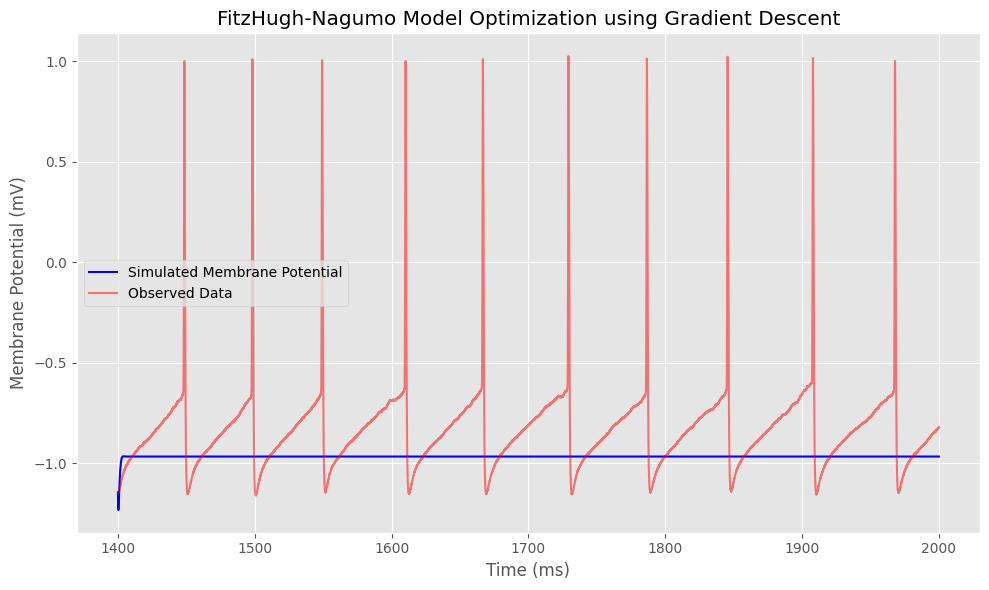

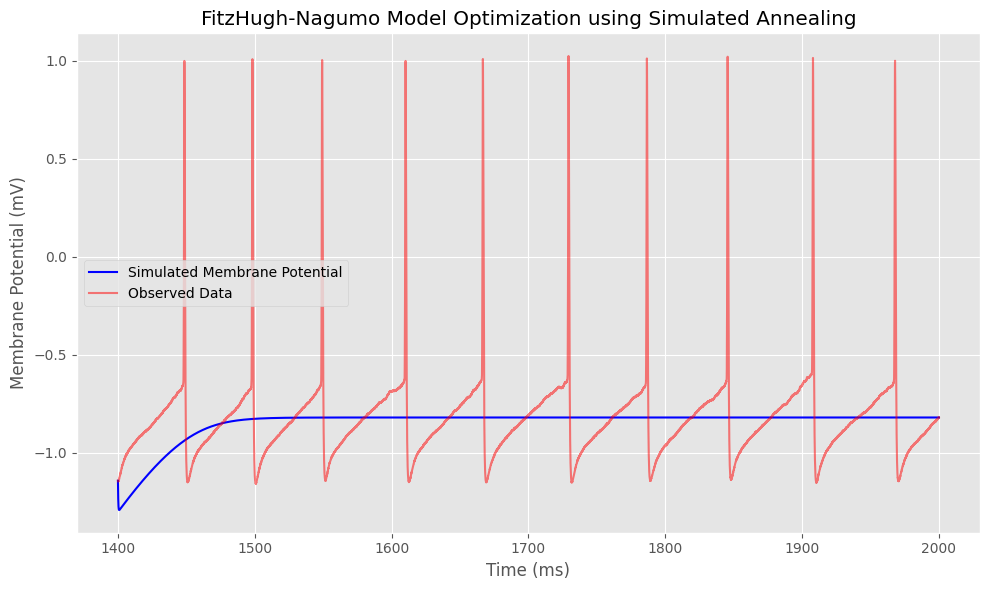

In [59]:
def plot_results(best_params, method):
    a_opt, b_opt, epsilon_opt = best_params
    model = FitzHughNagumoModel(a_opt, b_opt, epsilon_opt, v_d[0], 1)
    num_steps = int((t_d[-1] - t_d[0]) / dt)
    model.simulate(num_steps, dt)
    time_points = np.linspace(t_d[0], t_d[-1], num_steps + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, model.history['V'], color='blue', label='Simulated Membrane Potential')
    plt.plot(t_d, v_d, color='red', label='Observed Data', alpha=0.5)
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane Potential (mV)")
    plt.title(f"FitzHugh-Nagumo Model Optimization using {method}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(best_params_gd, "Gradient Descent")
plot_results(best_params_sa, "Simulated Annealing")


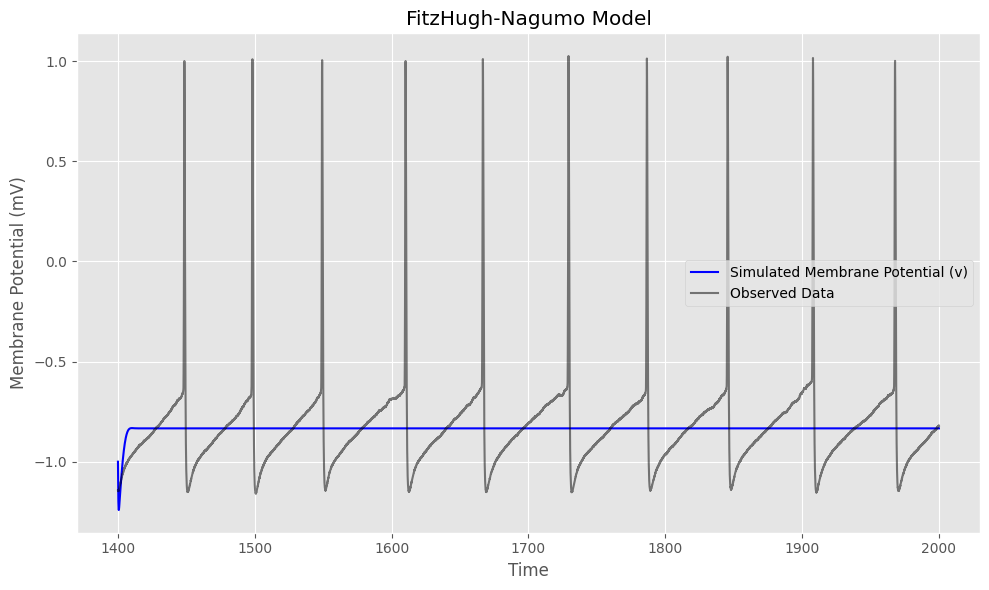

In [54]:
model = FitzHughNagumoModel(a_best, b_best, epsilon_best, -1, 1)
num_steps = int((t_d[-1] - t_d[0]) / dt)
model.simulate(num_steps, dt)

time_points = np.linspace(t_d[0], t_d[-1], num_steps + 1)

plt.figure(figsize=(10, 6))
plt.plot(time_points, model.history['V'], color='blue', label="Simulated Membrane Potential (v)")
plt.plot(t_d, v_d, label="Observed Data", color="black", alpha=0.5)
plt.title('FitzHugh-Nagumo Model')
plt.xlabel('Time')
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.tight_layout()
plt.show()


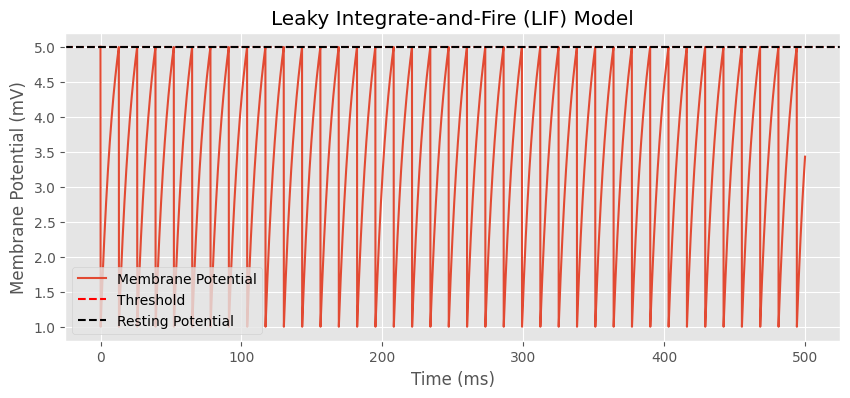

In [18]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.1
T = 500
time = np.arange(0, T, dt)

tau_m = 10.0
R_m = 1.0
V_th = 5
V_reset = 1
V_rest = 5.0
I_ext = 1.5

V = np.zeros_like(time)
V[0] = V_rest

for t in range(1, len(time)):
    dV = (-(V[t-1] - V_rest) + R_m * I_ext) / tau_m * dt
    V[t] = V[t-1] + dV

    if V[t] >= V_th:
        V[t] = V_reset

plt.figure(figsize=(10, 4))
plt.plot(time, V, label='Membrane Potential')
plt.axhline(y=V_th, color='r', linestyle='--', label='Threshold')
plt.axhline(y=V_rest, color='k', linestyle='--', label='Resting Potential')
plt.title('Leaky Integrate-and-Fire (LIF) Model')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.show()
